# SDSC3001 - Course Project

## Jaccard similarity coefficient

In [1]:
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)


# Example usage
set1 = {"a", "b", "c", "d"}
set2 = {"c", "d", "e", "f"}

similarity = jaccard_similarity(set1, set2)
print(f"Jaccard Similarity: {similarity}")

Jaccard Similarity: 0.3333333333333333


## Sketching techniques for the Jaccard similarity coefficient

In [2]:
import math
import mmh3
import numpy as np
import polars as pl
import random

random_seed = 42
random.seed(random_seed)
# Parameters
k = 128  # Number of hash functions
n = 10_000  # cardinality of the sets

In [3]:
def generate_balanced_synthetic_stream(n, jaccard_true):
    total_num = n * 2
    similarity_coefficient = (2 * jaccard_true) / (1 + jaccard_true)
    the_same_index = total_num / 2 * similarity_coefficient
    setA_uni_index = total_num / 2 * 1
    setB_uni_index = total_num / 2 * (2 - similarity_coefficient)

    stream = []
    for num in range(total_num):
        if num <= the_same_index:
            stream.append(["setA", num])
            stream.append(["setB", num])
        elif num <= setA_uni_index:
            stream.append(["setA", num])
        elif num <= setB_uni_index:
            stream.append(["setB", num])
        else:
            break
    return stream

In [4]:
def generate_unbalanced_synthetic_stream(n, jaccard_true): ...

### MinHash

In [5]:
class MinHash:
    def __init__(self, k, random_seed=random_seed):
        """
        Initialize MinHash
        k: number of hash functions
        random_seed: random seed for reproducibility
        """
        self.k = k
        self.seed = random_seed
        self.totalShingles = (1 << 32) - 1
        self.minHashSignatures = {}  # Store signatures for each set
        self.randomNoA = self._hash_parameter()
        self.randomNoB = self._hash_parameter()

    def _hash_parameter(self):
        """Generate random hash parameters"""
        randList = []
        k_temp = self.k
        randIndex = random.randint(0, self.totalShingles - 1)
        randList.append(randIndex)
        while k_temp > 0:
            while randIndex in randList:
                randIndex = random.randint(0, self.totalShingles - 1)
            randList.append(randIndex)
            k_temp -= 1
        return randList

    def process_stream(self, stream):
        """
        Process streaming data
        stream: list of [set_id, element] pairs
        """
        for item in stream:
            set_id, element = item[0], item[1]

            # Initialize signature if not exists
            if set_id not in self.minHashSignatures:
                self.minHashSignatures[set_id] = [float("inf")] * self.k

            # Update minimum hash values
            for i in range(self.k):
                hash_value = (
                    self.randomNoA[i] * mmh3.hash(str(element), self.seed) + self.randomNoB[i]
                ) % self.totalShingles
                self.minHashSignatures[set_id][i] = min(self.minHashSignatures[set_id][i], hash_value)

    def estimate_similarity(self, setA="setA", setB="setB"):
        """
        Estimate Jaccard similarity between two sets
        setA, setB: identifiers of the sets to compare
        """
        if setA not in self.minHashSignatures or setB not in self.minHashSignatures:
            raise ValueError("Sets not found in signatures")

        # Count matching signatures
        matches = sum(1 for i in range(self.k) if self.minHashSignatures[setA][i] == self.minHashSignatures[setB][i])

        # Estimate Jaccard similarity
        return matches / self.k

### b-bit MinHash

In [6]:
class B_bitMinHash:
    def __init__(self, k, b, random_seed=random_seed):
        """
        Initialize b-bit MinHash
        k: number of hash functions
        b: number of bits to keep from each hash value
        random_seed: random seed for reproducibility
        """
        self.k = k
        self.b = b
        self.seed = random_seed
        self.totalShingles = (1 << 32) - 1
        self.minHashSignatures = {}  # Store original MinHash signatures
        self.bbitSignatures = {}  # Store b-bit signatures
        self.randomNoA = self._hash_parameter()
        self.randomNoB = self._hash_parameter()
        self.mask = (1 << b) - 1  # Mask for getting lowest b bits

    def _hash_parameter(self):
        """Generate random hash parameters"""
        randList = []
        k_temp = self.k
        randIndex = random.randint(0, self.totalShingles - 1)
        randList.append(randIndex)
        while k_temp > 0:
            while randIndex in randList:
                randIndex = random.randint(0, self.totalShingles - 1)
            randList.append(randIndex)
            k_temp -= 1
        return randList

    def _get_lowest_b_bits(self, value):
        """Extract lowest b bits from a value"""
        return value & self.mask

    def process_stream(self, stream):
        """
        Process streaming data
        stream: list of [set_id, element] pairs
        """
        # First compute regular MinHash signatures
        for item in stream:
            set_id, element = item[0], item[1]

            # Initialize signature if not exists
            if set_id not in self.minHashSignatures:
                self.minHashSignatures[set_id] = [float("inf")] * self.k

            # Update minimum hash values
            for i in range(self.k):
                hash_value = (
                    self.randomNoA[i] * mmh3.hash(str(element), self.seed) + self.randomNoB[i]
                ) % self.totalShingles
                self.minHashSignatures[set_id][i] = min(self.minHashSignatures[set_id][i], hash_value)

        # Convert MinHash signatures to b-bit signatures
        for set_id in self.minHashSignatures:
            self.bbitSignatures[set_id] = [
                self._get_lowest_b_bits(int(value)) for value in self.minHashSignatures[set_id]
            ]

    def estimate_similarity(self, setA="setA", setB="setB"):
        """
        Estimate Jaccard similarity between two sets using b-bit MinHash
        setA, setB: identifiers of the sets to compare
        """
        if setA not in self.bbitSignatures or setB not in self.bbitSignatures:
            raise ValueError("Sets not found in signatures")

        # Count matching b-bit signatures
        matches = sum(1 for i in range(self.k) if self.bbitSignatures[setA][i] == self.bbitSignatures[setB][i])

        # Estimate Jaccard similarity using b-bit MinHash formula
        # Formula: (matches/k - 1/2^b)/(1 - 1/2^b)
        denominator = 1.0 - 1.0 / (1 << self.b)
        numerator = matches / float(self.k) - 1.0 / (1 << self.b)

        return numerator / denominator

### Odd Sketch

In [7]:
class OddSketch:
    def __init__(self, k, z, random_seed=random_seed):
        """
        Initialize Odd Sketch
        k: number of hash functions (for MinHash)
        z: number of bits in Odd Sketch
        random_seed: random seed for reproducibility
        """
        self.k = k
        self.z = z
        self.seed = random_seed
        self.totalShingles = (1 << 32) - 1
        self.minHashSignatures = {}  # Store MinHash signatures
        self.oddSketches = {}  # Store Odd Sketches
        self.randomNoA = self._hash_parameter()
        self.randomNoB = self._hash_parameter()

    def _hash_parameter(self):
        """Generate random hash parameters"""
        randList = []
        k_temp = self.k
        randIndex = random.randint(0, self.totalShingles - 1)
        randList.append(randIndex)
        while k_temp > 0:
            while randIndex in randList:
                randIndex = random.randint(0, self.totalShingles - 1)
            randList.append(randIndex)
            k_temp -= 1
        return randList

    def _compute_odd_sketch(self, minhash_signature):
        """
        Compute Odd Sketch from MinHash signature
        Uses XOR-based sketching
        """
        odd_sketch = np.zeros(self.z, dtype=bool)

        for i in range(self.k):
            # Hash (i, minhash_value) to position in odd sketch
            position = mmh3.hash(str((i, minhash_signature[i])), self.seed) % self.z
            odd_sketch[position] ^= True  # XOR operation

        return odd_sketch

    def process_stream(self, stream):
        """
        Process streaming data
        stream: list of [set_id, element] pairs
        """
        # First compute regular MinHash signatures
        for item in stream:
            set_id, element = item[0], item[1]

            # Initialize signature if not exists
            if set_id not in self.minHashSignatures:
                self.minHashSignatures[set_id] = [float("inf")] * self.k

            # Update minimum hash values
            for i in range(self.k):
                hash_value = (
                    self.randomNoA[i] * mmh3.hash(str(element), self.seed) + self.randomNoB[i]
                ) % self.totalShingles
                self.minHashSignatures[set_id][i] = min(self.minHashSignatures[set_id][i], hash_value)

        # Convert MinHash signatures to Odd Sketches
        for set_id in self.minHashSignatures:
            self.oddSketches[set_id] = self._compute_odd_sketch(self.minHashSignatures[set_id])

    def estimate_similarity(self, setA="setA", setB="setB"):
        """
        Estimate Jaccard similarity between two sets using Odd Sketch
        setA, setB: identifiers of the sets to compare
        """
        if setA not in self.oddSketches or setB not in self.oddSketches:
            raise ValueError("Sets not found in sketches")

        # Count differing bits between odd sketches
        hamming_distance = np.sum(self.oddSketches[setA] != self.oddSketches[setB])

        # Estimate Jaccard similarity using Odd Sketch formula
        # J = 1 + (z/4k)ln(1 - 2d/z)
        # where d is the Hamming distance and z is the sketch size
        if hamming_distance == self.z:
            return 0.0

        similarity = 1.0 + (self.z / (4.0 * self.k)) * np.log(1.0 - (2.0 * hamming_distance) / self.z)

        # Clamp similarity to [0,1]
        return max(0.0, min(1.0, similarity))


## MaxLogHash

In [8]:
class MaxLogHash:
    def __init__(self, k, random_seed=random_seed):
        self.k = k
        self.seed = random_seed
        self.totalShingles = (1 << 32) - 1
        self.maxShingleID = {}
        self.randomNoA = self._hash_parameter()
        self.randomNoB = self._hash_parameter()

    def _hash_parameter(self):
        randList = []
        k_temp = self.k
        randIndex = random.randint(0, self.totalShingles - 1)
        randList.append(randIndex)
        while k_temp > 0:
            while randIndex in randList:
                randIndex = random.randint(0, self.totalShingles - 1)
            randList.append(randIndex)
            k_temp -= 1
        return randList

    def process_stream(self, stream):
        for item in stream:
            if item[0] in self.maxShingleID:
                max_hash_val_list = self.maxShingleID[item[0]][0]
                max_hash_sig_list = self.maxShingleID[item[0]][1]

                for x in range(self.k):
                    temp = (
                        self.randomNoA[x] * mmh3.hash(str(item[1]), self.seed) + self.randomNoB[x]
                    ) % self.totalShingles
                    temp = temp / float(self.totalShingles)
                    log_temp = -math.log(temp, 2)
                    hash_val = math.ceil(log_temp)

                    if hash_val > max_hash_val_list[x]:
                        max_hash_val_list[x] = hash_val
                        max_hash_sig_list[x] = 1
                    elif hash_val == max_hash_val_list[x]:
                        max_hash_sig_list[x] = 0

                self.maxShingleID[item[0]][0] = max_hash_val_list
                self.maxShingleID[item[0]][1] = max_hash_sig_list
            else:
                max_hash_val_list = [-1] * self.k
                max_hash_sig_list = [0] * self.k
                self.maxShingleID[item[0]] = [max_hash_val_list, max_hash_sig_list]

    def estimate_similarity(self, setA="setA", setB="setB"):
        con = 0
        for x in range(self.k):
            if self.maxShingleID[setA][0][x] > self.maxShingleID[setB][0][x] and self.maxShingleID[setA][1][x] == 1:
                con += 1
            elif self.maxShingleID[setA][0][x] < self.maxShingleID[setB][0][x] and self.maxShingleID[setB][1][x] == 1:
                con += 1

        jaccard_sim = 1.0 - con * (1 / float(self.k)) * (1 / 0.7213)
        return jaccard_sim

## Datasets

### Synthetic datasets

Generate set A by randomly selecting n different numbers from I

Generate set B by randomly selecting $|A \cup B| = \frac{J_{A, B}|A|}{1+J_{A, B}}$ different numbers from set A and $n - |A \cup B|$ different numbers from set I\A

n = 10,000 by default

- Balanced set-pairs (i.e., |A| = |B| = n)
- Unbalanced set-pairs (i.e., |A| != |B|)

In [9]:
def compare_all_methods(jaccard_true, k=128, n=10000):
    """
    Compare all similarity estimation methods
    jaccard_true: true Jaccard similarity
    k: number of hash functions
    n: number of elements in the stream (cardinality)
    """

    # Generate synthetic stream
    stream = generate_balanced_synthetic_stream(n, jaccard_true)
    # print(stream[:10])

    # Regular MinHash estimation
    minhash = MinHash(k)
    minhash.process_stream(stream)
    jaccard_est_min = minhash.estimate_similarity()

    # b-bit MinHash estimation
    b = 1  # b-bit MinHash parameter
    bbit_minhash = B_bitMinHash(k, b)
    bbit_minhash.process_stream(stream)
    jaccard_est_bbit = bbit_minhash.estimate_similarity()

    # Odd Sketch estimation
    z = 512  # Odd Sketch size
    odd_sketch = OddSketch(k, z)
    odd_sketch.process_stream(stream)
    jaccard_est_odd = odd_sketch.estimate_similarity()

    # MaxLogHash estimation
    maxlog = MaxLogHash(k)
    maxlog.process_stream(stream)
    jaccard_est_max = maxlog.estimate_similarity()

    # print(f"{jaccard_true}, {jaccard_est_min}, {jaccard_est_bbit}, {jaccard_est_odd}, {jaccard_est_max}")
    return jaccard_est_min, jaccard_est_bbit, jaccard_est_odd, jaccard_est_max

In [10]:
compare_all_methods(0.8)

(0.78125, 0.78125, 0.8841681844748783, 0.740052682656315)

In [11]:
# Initialize an empty list to store results
results = []

for i in range(80, 101):
    jaccard_true = i / 100
    jaccard_est_min, jaccard_est_bbit, jaccard_est_odd, jaccard_est_max = compare_all_methods(jaccard_true)

    # Append the results to the list
    results.append([jaccard_true, jaccard_est_min, jaccard_est_bbit, jaccard_est_odd, jaccard_est_max])

In [12]:
# Create a DataFrame from the results
columns = ["True Jaccard", "MinHash", "b-bit MinHash", "Odd Sketch", "MaxLogHash"]
df = pl.DataFrame(results, schema=columns, orient="row")

# Display the DataFrame
print(df)

shape: (21, 5)
┌──────────────┬───────────┬───────────────┬────────────┬────────────┐
│ True Jaccard ┆ MinHash   ┆ b-bit MinHash ┆ Odd Sketch ┆ MaxLogHash │
│ ---          ┆ ---       ┆ ---           ┆ ---        ┆ ---        │
│ f64          ┆ f64       ┆ f64           ┆ f64        ┆ f64        │
╞══════════════╪═══════════╪═══════════════╪════════════╪════════════╡
│ 0.8          ┆ 0.8359375 ┆ 0.796875      ┆ 0.84845    ┆ 0.750884   │
│ 0.81         ┆ 0.8046875 ┆ 0.796875      ┆ 0.811409   ┆ 0.80504    │
│ 0.82         ┆ 0.8046875 ┆ 0.765625      ┆ 0.875358   ┆ 0.859195   │
│ 0.83         ┆ 0.8359375 ┆ 0.8125        ┆ 0.80193    ┆ 0.837533   │
│ 0.84         ┆ 0.796875  ┆ 0.84375       ┆ 0.884168   ┆ 0.783377   │
│ …            ┆ …         ┆ …             ┆ …          ┆ …          │
│ 0.96         ┆ 0.9609375 ┆ 0.90625       ┆ 0.918654   ┆ 0.956675   │
│ 0.97         ┆ 0.984375  ┆ 0.984375      ┆ 0.976283   ┆ 0.989169   │
│ 0.98         ┆ 0.9765625 ┆ 0.96875       ┆ 0.992157   ┆ 0.98

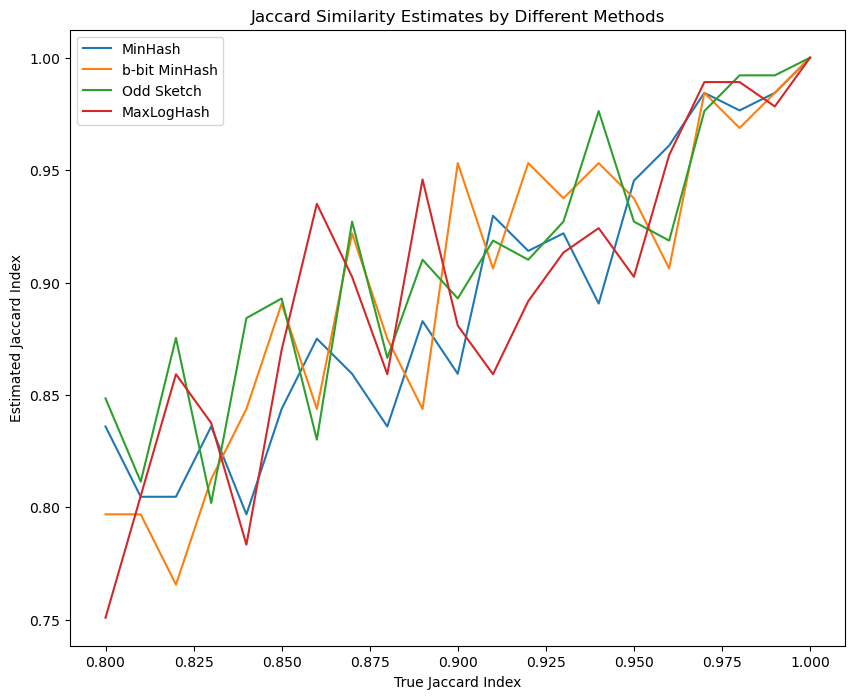

In [13]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Plot the data
for method in columns[1:]:
    plt.plot(df["True Jaccard"], df[method], label=method)

# Set the title and labels
plt.title("Jaccard Similarity Estimates by Different Methods")
plt.xlabel("True Jaccard Index")
plt.ylabel("Estimated Jaccard Index")

# Add a legend
plt.legend()

# Show the plot
plt.show()

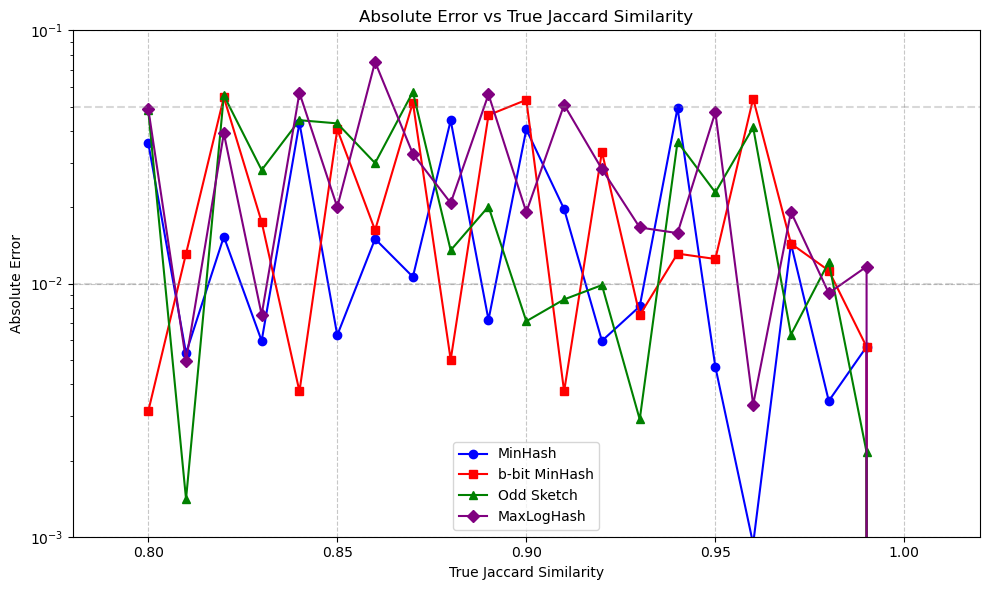

In [14]:
import matplotlib.pyplot as plt

# Calculate absolute errors
df = df.with_columns(
    [
        pl.col("MinHash").sub(pl.col("True Jaccard")).abs().alias("MinHash_error"),
        pl.col("b-bit MinHash").sub(pl.col("True Jaccard")).abs().alias("bbit_error"),
        pl.col("Odd Sketch").sub(pl.col("True Jaccard")).abs().alias("oddsketch_error"),
        pl.col("MaxLogHash").sub(pl.col("True Jaccard")).abs().alias("maxlog_error"),
    ]
)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each method's error
plt.plot(df["True Jaccard"], df["MinHash_error"], "o-", label="MinHash", color="blue")
plt.plot(df["True Jaccard"], df["bbit_error"], "s-", label="b-bit MinHash", color="red")
plt.plot(df["True Jaccard"], df["oddsketch_error"], "^-", label="Odd Sketch", color="green")
plt.plot(df["True Jaccard"], df["maxlog_error"], "D-", label="MaxLogHash", color="purple")

# Customize the plot
plt.xlabel("True Jaccard Similarity")
plt.ylabel("Absolute Error")
plt.title("Absolute Error vs True Jaccard Similarity")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Set x-axis limits
plt.xlim(0.78, 1.02)

# Format y-axis to show small values clearly
plt.yscale("log")  # Use log scale for better visualization of small errors
plt.ylim(0.001, 0.1)

# Add horizontal lines for reference
plt.axhline(y=0.01, color="gray", linestyle="--", alpha=0.3)
plt.axhline(y=0.05, color="gray", linestyle="--", alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Real-world datasets

In [15]:
def load_dataset(filepath):
    with open(filepath, "r") as file:
        dataset = pl.DataFrame(np.loadtxt(file, dtype=int))

    item_record_pairs = {}

    for record_id, record in enumerate(dataset):
        for item in record:
            if item not in item_record_pairs:
                item_record_pairs[item] = []
            item_record_pairs[item].append(record_id)

    pairs = [(item, rec) for item, recs in item_record_pairs.items() for rec in recs]

    return dataset, item_record_pairs, pairs

#### MUSHROOM dataset

In [16]:
mushroom_dataset_path = "./data/mushroom.dat"
mushroom = load_dataset(mushroom_dataset_path)

mushroom_dataset = mushroom[0]
mushroom_item_record_pairs = mushroom[1]
mushroom_pairs = mushroom[2]

- 8,124 records with 119 distinct items
- 186,852 item-record pairs

In [17]:
print(mushroom_dataset[:5])
print(mushroom_dataset.shape)
print(len(mushroom_item_record_pairs))
print(len(mushroom_pairs))

shape: (5, 23)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_0 ┆ column_1 ┆ column_2 ┆ column_3 ┆ … ┆ column_19 ┆ column_20 ┆ column_21 ┆ column_22 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i32      ┆ i32      ┆ i32      ┆ i32      ┆   ┆ i32       ┆ i32       ┆ i32       ┆ i32       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1        ┆ 3        ┆ 9        ┆ 13       ┆ … ┆ 93        ┆ 98        ┆ 107       ┆ 113       │
│ 2        ┆ 3        ┆ 9        ┆ 14       ┆ … ┆ 93        ┆ 99        ┆ 108       ┆ 114       │
│ 2        ┆ 4        ┆ 9        ┆ 15       ┆ … ┆ 93        ┆ 99        ┆ 108       ┆ 115       │
│ 1        ┆ 3        ┆ 10       ┆ 15       ┆ … ┆ 93        ┆ 98        ┆ 107       ┆ 113       │
│ 2        ┆ 3        ┆ 9        ┆ 16       ┆ … ┆ 94        ┆ 99        ┆ 109       ┆ 114       │
└────

In [18]:
# def create_stream_from_dataset(dataset):
#     """
#     Convert dataset into a stream of [item_id, record_id] pairs
#     dataset: DataFrame where each row is a record containing items

#     Returns:
#     stream: list of [item_id, record_id] pairs
#     """
#     stream = []

#     # Iterate through each record
#     for record_id, record in enumerate(dataset.iter_rows()):
#         # For each item in the record
#         for item in record:
#             if item != 0:  # Assuming 0 is not a valid item ID
#                 # Add (item, record) pair to stream
#                 stream.append([f"set{record_id}", item])
#                 # print(record_id, item)

#     return stream


# def analyze_stream(stream):
#     """
#     Print statistics about the stream
#     """
#     unique_items = len(set(pair[0] for pair in stream))
#     unique_records = len(set(pair[1] for pair in stream))
#     total_pairs = len(stream)

#     print(f"Number of unique items: {unique_items}")
#     print(f"Number of records: {unique_records}")
#     print(f"Total item-record pairs: {total_pairs}")

# # To estimate similarity between two items
# def get_item_similarity(minhash, item1, item2):
#     return minhash.estimate_similarity(f"item_{item1}", f"item_{item2}")

In [19]:
# # Convert mushroom_dataset to a stream of [set_id, element] pairs
# stream = []

# for record_id, record in enumerate(mushroom_dataset):
#     for item in record:
#         stream.append([f"set{record_id}", item])

# # Now you can pass the stream to the sketch methods
# # Example usage with MinHash
# minhash = MinHash(k=128)
# minhash.process_stream(stream)
# jaccard_est_min = minhash.estimate_similarity(setA="set0", setB="set1")

# # Example usage with MaxLogHash
# maxlog = MaxLogHash(k=128)
# maxlog.process_stream(stream)
# jaccard_est_max = maxlog.estimate_similarity(setA="set0", setB="set1")

# print(f"MinHash Jaccard Estimate: {jaccard_est_min}")
# print(f"MaxLogHash Jaccard Estimate: {jaccard_est_max}")

#### CONNECT dataset

In [20]:
connect_dataset_path = "./data/connect.dat"
connect = load_dataset(connect_dataset_path)

connect_dataset = connect[0]
connect_item_record_pairs = connect[1]
connect_pairs = connect[2]

- 67,557 records with 127 distinct items
- 2,904,951 item-record pairs

In [21]:
print(connect_dataset[:5])
print(connect_dataset.shape)
print(len(connect_item_record_pairs))
print(len(connect_pairs))

shape: (5, 43)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ column_0 ┆ column_1 ┆ column_2 ┆ column_3 ┆ … ┆ column_39 ┆ column_40 ┆ column_41 ┆ column_42 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i32      ┆ i32      ┆ i32      ┆ i32      ┆   ┆ i32       ┆ i32       ┆ i32       ┆ i32       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1        ┆ 4        ┆ 7        ┆ 10       ┆ … ┆ 118       ┆ 121       ┆ 124       ┆ 127       │
│ 1        ┆ 4        ┆ 7        ┆ 10       ┆ … ┆ 118       ┆ 121       ┆ 124       ┆ 127       │
│ 1        ┆ 4        ┆ 7        ┆ 10       ┆ … ┆ 118       ┆ 121       ┆ 124       ┆ 127       │
│ 1        ┆ 4        ┆ 7        ┆ 10       ┆ … ┆ 118       ┆ 121       ┆ 124       ┆ 127       │
│ 1        ┆ 5        ┆ 7        ┆ 10       ┆ … ┆ 118       ┆ 121       ┆ 124       ┆ 127       │
└────